In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

In [2]:
#mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
#inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

In [3]:
import pathlib

data_file = tf.keras.utils.get_file(
  'flower_photos.tgz',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
  cache_dir='.',
   extract=True)

data_root = pathlib.Path(data_file).with_suffix('')

228813984/228813984 [==============================] - 283s 1us/step


In [4]:
data_root

WindowsPath('datasets/flower_photos')

In [5]:
str(data_root)

'datasets\\flower_photos'

In [6]:
batch_size = 32
img_height = 224
img_width = 224

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [13]:
feature_extractor_layer = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4",input_shape=(224, 224, 3),trainable=False)

## The feature extractor returns a 1001-long vector for each image (the image batch size remains at 32 in this example)

In [14]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1001)


In [15]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(5,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
 dense (Dense)               (None, 5)                 5010      
                                                                 
Total params: 3,545,275
Trainable params: 5,010
Non-trainable params: 3,540,265
_________________________________________________________________


In [16]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [17]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS)

Epoch 1/10
92/92 [==============================] - 44s 455ms/step - loss: 0.7444 - accuracy: 0.7466 - val_loss: 0.4409 - val_accuracy: 0.8501
Epoch 2/10
92/92 [==============================] - 35s 380ms/step - loss: 0.3585 - accuracy: 0.8726 - val_loss: 0.3829 - val_accuracy: 0.8638
Epoch 3/10
92/92 [==============================] - 36s 390ms/step - loss: 0.2816 - accuracy: 0.9019 - val_loss: 0.3669 - val_accuracy: 0.8719
Epoch 4/10
92/92 [==============================] - 37s 399ms/step - loss: 0.2382 - accuracy: 0.9213 - val_loss: 0.3632 - val_accuracy: 0.8801
Epoch 5/10
92/92 [==============================] - 36s 392ms/step - loss: 0.2089 - accuracy: 0.9339 - val_loss: 0.3644 - val_accuracy: 0.8774
Epoch 6/10
92/92 [==============================] - 36s 394ms/step - loss: 0.1869 - accuracy: 0.9421 - val_loss: 0.3675 - val_accuracy: 0.8787
Epoch 7/10
92/92 [==============================] - 36s 392ms/step - loss: 0.1694 - accuracy: 0.9489 - val_loss: 0.3714 - val_accuracy: 0.8828

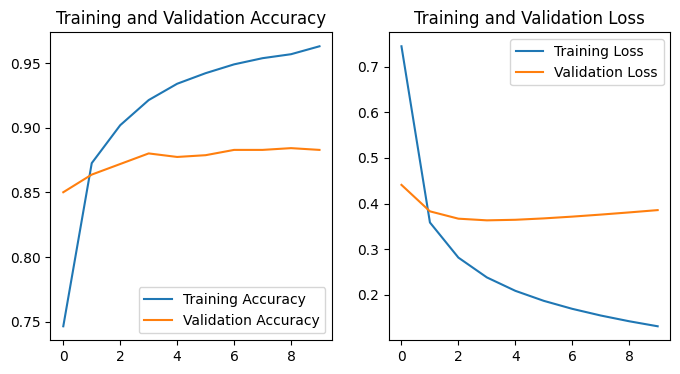

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
predicted_batch = model.predict(image_batch)

1/1 [==============================] - 1s 651ms/step


In [20]:
predicted_batch

array([[4.3008156e-05, 9.9995637e-01, 9.0235535e-09, 6.0396928e-08,
        4.4790676e-07],
       [1.9167913e-01, 6.1462837e-01, 2.1846532e-03, 1.7742339e-01,
        1.4084415e-02],
       [3.9747928e-04, 1.0743968e-03, 1.9841986e-05, 9.9848360e-01,
        2.4775130e-05],
       [5.8350448e-02, 1.6928077e-02, 7.9703414e-01, 8.7151237e-02,
        4.0536027e-02],
       [4.9500511e-04, 2.4938892e-04, 1.8678652e-02, 1.1619804e-01,
        8.6437893e-01],
       [3.4596763e-07, 3.9341369e-10, 9.9989605e-01, 6.2223345e-11,
        1.0357567e-04],
       [1.0492863e-03, 3.4043595e-02, 2.5345732e-03, 7.6170820e-01,
        2.0066433e-01],
       [9.9456827e-07, 9.9999905e-01, 6.8080794e-09, 6.5877392e-09,
        4.8215507e-09],
       [5.6332277e-07, 7.0579262e-07, 9.9900180e-01, 4.2865554e-07,
        9.9648535e-04],
       [4.6783567e-05, 7.4446527e-04, 6.0627717e-03, 1.7100661e-04,
        9.9297500e-01],
       [9.8655391e-03, 9.6878976e-01, 3.8469993e-03, 2.5226686e-03,
        1.49

In [21]:
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_id

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1, 1, 3, 2, 4, 2, 3, 1, 2, 4, 1, 1, 1, 1, 3, 0, 0, 4, 1, 3, 0, 3,
       4, 1, 4, 4, 0, 1, 2, 3, 1, 3], dtype=int64)>

In [22]:
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['dandelion' 'dandelion' 'sunflowers' 'roses' 'tulips' 'roses'
 'sunflowers' 'dandelion' 'roses' 'tulips' 'dandelion' 'dandelion'
 'dandelion' 'dandelion' 'sunflowers' 'daisy' 'daisy' 'tulips' 'dandelion'
 'sunflowers' 'daisy' 'sunflowers' 'tulips' 'dandelion' 'tulips' 'tulips'
 'daisy' 'dandelion' 'roses' 'sunflowers' 'dandelion' 'sunflowers']


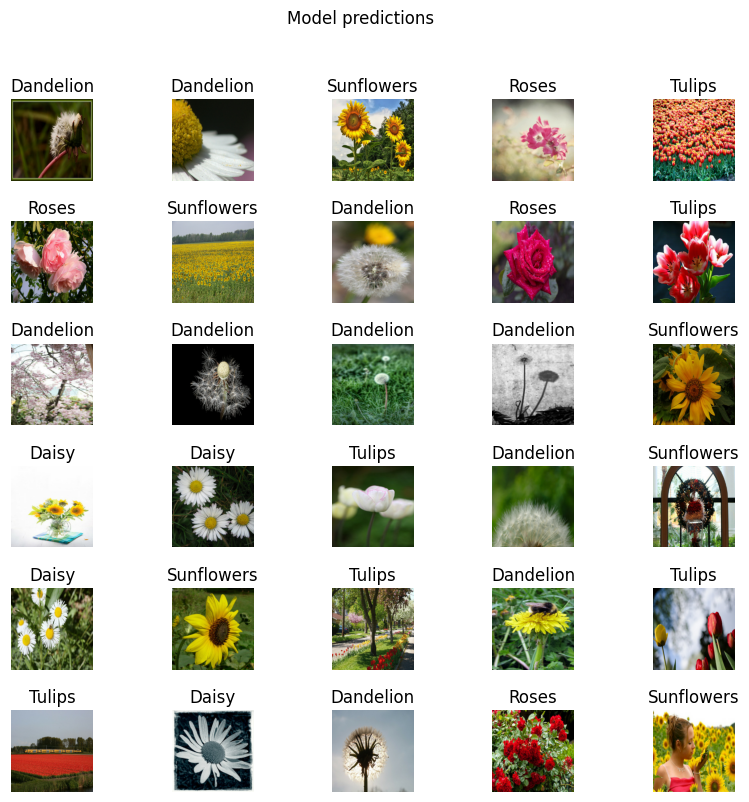

In [23]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")